In [4]:
import pandas as pd
import numpy as np
import statsmodels.stats.api as sms
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data that contains information about user_id, time, group, landing_page and converted 
data = pd.read_csv("marketing_AB.csv", index_col=0)

In [5]:
data.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [7]:
data.rename(columns={"user id": "user_id", "test group":"test_group", "total ads":"total_ads", "most ads day": "most_ads_day", "most ads hour": "most_ads_hour"}, inplace=True)
data.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


# define hypothesis
Two-tailed test as we do not know which group (psa or ad) performs better 
Null hypothesis: The conversion rate for the two groups is the same
𝐻0:𝑝=𝑝0
 
Alternative Hypothesis: The conversion rate for the two groups is not the same
𝐻1:𝑝≠𝑝0
 
where  𝑝
  is the conversion rate for the psa, and  𝑝0
  is the conversion rate for the ads

Let's set a confidence interval of  95%, hence our level of significance will be  𝛼=1−0.95=5%

In [10]:
data['test_group'].value_counts()

test_group
ad     564577
psa     23524
Name: count, dtype: int64

In [11]:
#check for null values
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        588101 non-null  int64 
 1   test_group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total_ads      588101 non-null  int64 
 4   most_ads_day   588101 non-null  object
 5   most_ads_hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 27.5+ MB


In [12]:
# check for multiple user_ids
user_sessions = data['user_id'].value_counts()
user_sessions[user_sessions > 1].count()

np.int64(0)

In [13]:
ad_group = data[data['test_group'] == "ad"]
psa_group = data[data['test_group']=="psa"]

In [14]:

effect_size = sms.proportion_effectsize(0.10, 0.15) # effect size are essential in power analysis to determine the sample size required to detect statistically significant effect

sample_size = sms.NormalIndPower().solve_power(
    effect_size,
    power = 0.8,  # detect the effect size with 80% probability. 
    alpha = 0.05, # willing to accept a 5% chance of false positives.
    ratio = 1 # assuming equal sample sizes for both groups
)
sample_size = ceil(sample_size)
sample_size

681

In [15]:
trt_sample = psa_group.sample(n=sample_size, random_state=12)
cntrl_sample = ad_group.sample(n=sample_size, random_state=12)

In [16]:
df = pd.concat([trt_sample, cntrl_sample], axis=0).reset_index(drop=True)
df.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,903088,psa,False,8,Friday,10
1,904967,psa,False,16,Saturday,19
2,906270,psa,True,204,Monday,14
3,901402,psa,False,2,Friday,15
4,916840,psa,False,38,Friday,16


In [17]:
df['group'] = np.where(df['test_group'] == "psa", "treatment", "control")

In [18]:
df['converted'] = np.where(df['converted']==True, 1, 0)

In [19]:
df['converted'].value_counts()

converted
0    1335
1      27
Name: count, dtype: int64

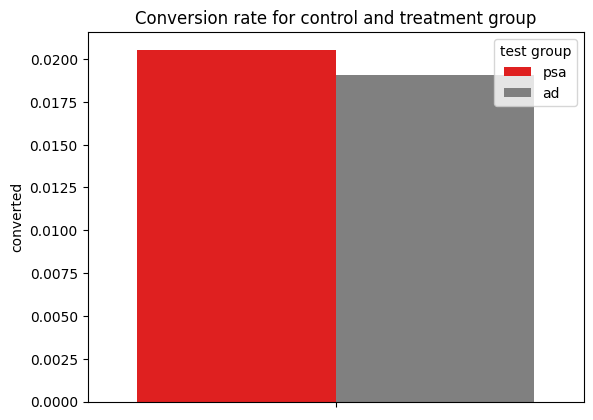

In [70]:
sns.barplot(data=df, hue="test_group", y="converted", palette=["red", "grey"], errorbar=('ci', False))
plt.title('Conversion rate for control and treatment group')
plt.show()

In [20]:
# calculate p-value 
cntrl_conversion = df[df['group'] == "control"]['converted']
trt_conversion = df[df['group'] == "treatment"]['converted']

num_converted = [cntrl_conversion.sum(), trt_conversion.sum()]
nobs = [cntrl_conversion.count(), trt_conversion.count()]

z_stat, pval = sms.proportions_ztest(num_converted, nobs=nobs)

pval  # p>0.1 No evidence for rejecting null hypothesis

np.float64(0.8458732812504042)

The p-value obtained is greater than 0.05, we cannot reject the null hypothesis that the conversion rates for the psa and ad groups are the same.

Based on the analysis, the conversion rates for the psa and ad groups are not significantly different. This suggests that the company may want to reconsider its resource allocation strategy and explore ways to optimize both groups to improve overall conversion rates. 